In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from keras import layers
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout
from keras.models import Model

import keras.backend as K
from keras.models import Sequential

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

Using TensorFlow backend.


In [5]:
os.listdir("input/humpback-whale-identification/")

['train.zip',
 'train',
 'train.csv',
 'test',
 'test.zip',
 'sample_submission.csv']

In [6]:
train_df = pd.read_csv("input/humpback-whale-identification/train.csv")
train_df.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [7]:
def prepareImages(data, m, dataset):
    print("Preparing images")
    X_train = np.zeros((m, 100, 100, 3))
    count = 0
    
    for fig in data['Image']:
        #load images into images of size 100x100x3
        img = image.load_img("input/humpback-whale-identification/"+dataset+"/"+fig, target_size=(100, 100, 3))
        x = image.img_to_array(img)
        x = preprocess_input(x)

        X_train[count] = x
        if (count%500 == 0):
            print("Processing image: ", count+1, ", ", fig)
        count += 1
    
    return X_train

In [8]:
def prepare_labels(y):
    values = np.array(y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    # print(integer_encoded)

    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    # print(onehot_encoded)

    y = onehot_encoded
    # print(y.shape)
    return y, label_encoder

In [ ]:
import os
import numpy as np
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers
import scipy
import pylab as pl
import matplotlib.cm as cm
%matplotlib inline

input_shape = (100, 100, 3)
img_width = 100
img_height = 100

nb_train_samples = 2000
nb_validation_samples = 1000
batch_size = 16
epochs = 25

train_data_dir = 'input/humpback-whale-identification/train'
validation_data_dir = 'input/humpback-whale-identification/test'

# Creating our data generator for our test data
validation_datagen = ImageDataGenerator(
    # used to rescale the pixel values from [0, 255] to [0, 1] interval
    rescale = 1./255)

# Creating our data generator for our training data
train_datagen = ImageDataGenerator(
      rescale = 1./255,              # normalize pixel values to [0,1]
      rotation_range = 30,           # randomly applies rotations
      width_shift_range = 0.3,       # randomly applies width shifting
      height_shift_range = 0.3,      # randomly applies height shifting
      horizontal_flip = True,        # randonly flips the image
      fill_mode = 'nearest')         # uses the fill mode nearest to fill gaps created by the above

# Specify criteria about our training data, such as the directory, image size, batch size and type 
# automagically retrieve images and their classes for train and validation sets
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size = (img_width, img_height),
        batch_size = batch_size,
        class_mode = 'binary',
        shuffle = True)

validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size = (img_width, img_height),
        batch_size = batch_size,
        class_mode = 'binary',
        shuffle = False)   

In [9]:
X = prepareImages(train_df, train_df.shape[0], "train")
X /= 255

Preparing images
Processing image:  1 ,  0000e88ab.jpg
Processing image:  501 ,  04c72257b.jpg
Processing image:  1001 ,  09cacb84d.jpg
Processing image:  1501 ,  0ef961892.jpg
Processing image:  2001 ,  141b56a1a.jpg
Processing image:  2501 ,  199a417aa.jpg
Processing image:  3001 ,  1ec170983.jpg
Processing image:  3501 ,  23f084b93.jpg
Processing image:  4001 ,  29163ad0b.jpg
Processing image:  4501 ,  2e0fab120.jpg
Processing image:  5001 ,  3347515d9.jpg
Processing image:  5501 ,  3842d71dc.jpg
Processing image:  6001 ,  3d7f4c7d5.jpg
Processing image:  6501 ,  425f763ca.jpg
Processing image:  7001 ,  4714400cd.jpg
Processing image:  7501 ,  4c082fbdf.jpg
Processing image:  8001 ,  50c683e23.jpg
Processing image:  8501 ,  560d986ad.jpg
Processing image:  9001 ,  5b68c83ed.jpg
Processing image:  9501 ,  60410f111.jpg
Processing image:  10001 ,  654951f81.jpg
Processing image:  10501 ,  6a572256c.jpg
Processing image:  11001 ,  6f96f55b6.jpg
Processing image:  11501 ,  74da2b511.jpg

In [10]:
y, label_encoder = prepare_labels(train_df['Id'])

In [11]:
y.shape

(25361, 5005)

In [12]:
model = Sequential()

model.add(Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0', input_shape = (100, 100, 3)))

model.add(BatchNormalization(axis = 3, name = 'bn0'))
model.add(Activation('relu'))

model.add(MaxPooling2D((2, 2), name='max_pool'))
model.add(Conv2D(64, (3, 3), strides = (1,1), name="conv1"))
model.add(Activation('relu'))
model.add(AveragePooling2D((3, 3), name='avg_pool'))

model.add(Flatten())
model.add(Dense(500, activation="relu", name='rl'))
model.add(Dropout(0.8))
model.add(Dense(y.shape[1], activation='softmax', name='sm'))

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv0 (Conv2D)               (None, 94, 94, 32)        4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 94, 94, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 94, 94, 32)        0         
_________________________________________________________________
max_pool (MaxPooling2D)      (None, 47, 47, 32)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 45, 45, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 45, 45, 64)        0         
_________________________________________________________________
avg_pool (AveragePooling2D)  (None, 15, 15, 64)        0         
__________

In [13]:
history = model.fit(X, y, epochs=100, batch_size=100, verbose=1)

Epoch 1/100
25361/25361 [==============================] - 33s 1ms/step - loss: 6.1940 - acc: 0.3795
Epoch 2/100
25361/25361 [==============================] - 7s 287us/step - loss: 5.9227 - acc: 0.3811
Epoch 3/100
25361/25361 [==============================] - 7s 286us/step - loss: 5.8258 - acc: 0.3811
Epoch 4/100
25361/25361 [==============================] - 7s 286us/step - loss: 5.7583 - acc: 0.3811
Epoch 5/100
25361/25361 [==============================] - 7s 288us/step - loss: 5.7244 - acc: 0.3811
Epoch 6/100
25361/25361 [==============================] - 7s 287us/step - loss: 5.6975 - acc: 0.3811
Epoch 7/100
25361/25361 [==============================] - 7s 286us/step - loss: 5.6849 - acc: 0.3811
Epoch 8/100
25361/25361 [==============================] - 7s 291us/step - loss: 5.6564 - acc: 0.3811
Epoch 9/100
25361/25361 [==============================] - 7s 287us/step - loss: 5.6299 - acc: 0.3811
Epoch 10/100
25361/25361 [==============================] - 7s 287us/step - loss: 5

In [14]:
import gc
gc.collect()

0

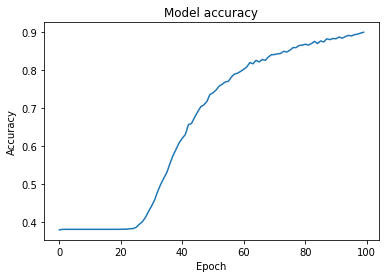

In [15]:
plt.plot(history.history['acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [16]:
test = os.listdir("input/humpback-whale-identification/test/")
print(len(test))

7960


In [17]:
col = ['Image']
test_df = pd.DataFrame(test, columns=col)
test_df['Id'] = ''

In [18]:
Y = prepareImages(test_df, test_df.shape[0], "test")
Y /= 255

Preparing images
Processing image:  1 ,  268acde04.jpg
Processing image:  501 ,  6d5df87ce.jpg
Processing image:  1001 ,  9082453bf.jpg
Processing image:  1501 ,  b5efaae83.jpg
Processing image:  2001 ,  41624877d.jpg
Processing image:  2501 ,  b0c1fcc72.jpg
Processing image:  3001 ,  de48e639c.jpg
Processing image:  3501 ,  67c9251c1.jpg
Processing image:  4001 ,  dddf9380e.jpg
Processing image:  4501 ,  bc6771f0a.jpg
Processing image:  5001 ,  201bca34c.jpg
Processing image:  5501 ,  534ca76dc.jpg
Processing image:  6001 ,  46f679d2c.jpg
Processing image:  6501 ,  2637f5914.jpg
Processing image:  7001 ,  69e66d121.jpg
Processing image:  7501 ,  cf8af3677.jpg


In [19]:
predictions = model.predict(np.array(Y), verbose=1)

7960/7960 [==============================] - 2s 201us/step


In [20]:
for i, pred in enumerate(predictions):
    test_df.loc[i, 'Id'] = ' '.join(label_encoder.inverse_transform(pred.argsort()[-5:][::-1]))

In [21]:
test_df.head(10)
test_df.to_csv('submission.csv', index=False)

In [22]:
model.save("./whalecnn1.h5")